### Convolutional Neural Network (CNN) for Processing and Classifying CIFAR-10 Images from Scratch

### Part 1: Initial Data Processing

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

np.random.seed(3)

Load up initial data from CIFAR-10:
* 10 classes of images (airplane, automobile, bird...)
* 6000 images per class (5000 train, 1000 test)

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

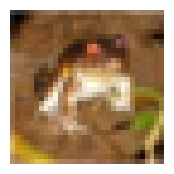

In [121]:
def load_batch_from_file(file_path):
    # load data from a CIFAR-10 batch file using pickle
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data = np.array(batch[b'data'])
    labels = np.array(batch[b'labels'])
    return data, labels


# reshape data into 3 channels of 32x32 images
data, labels = load_batch_from_file('cifar-10-batches-py/data_batch_1')
data_separated = data[0].reshape(3, 32, 32)

img = data_separated.transpose(1, 2, 0)  # (H, W, C)

# display first image for test
plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis("off")


Process all training and test batches from cifar-10-batches-py folder

In [122]:
def load_batches():
    X_list, Y_list = [], []

    # load training batches 1 to 5
    for i in range(1, 6):
        path = f'cifar-10-batches-py/data_batch_{i}'
        data, labels = load_batch_from_file(path)

        X_list.append(data)
        Y_list.append(labels)

    # concatenate all training batches
    X_train = np.concatenate(X_list)
    Y_train = np.concatenate(Y_list)

    # test batch
    X_test, Y_test = load_batch_from_file('cifar-10-batches-py/test_batch')

    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = load_batches()

# shapes
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

X_train: (50000, 3072)
Y_train: (50000,)
X_test: (10000, 3072)
Y_test: (10000,)


Reshape datasets into (3, 32, 32) and normalize

In [123]:
# reshape to (N, 3, 32, 32)
X_train = X_train.reshape(-1, 3, 32, 32)
X_test = X_test.reshape(-1, 3, 32, 32)

print("X_train reshaped:", X_train.shape)
print("X_test reshaped:", X_test.shape)

# normalize pixel values to [0, 1] and convert to float32 for precision
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

X_train reshaped: (50000, 3, 32, 32)
X_test reshaped: (10000, 3, 32, 32)


Utility functions for later. Split train into train + validation and iterate through batches during training

In [124]:
def train_val_split(X, Y, ratio=0.1):
    """
    Split the training data into new training and validation sets.
    """
    N = len(X)
    random_indices = np.random.permutation(N)
    val_size = int(N * ratio)

    # calculate validation and new training indices
    val_i = random_indices[:val_size]
    train_i = random_indices[val_size:]

    X_val, Y_val = X[val_i], Y[val_i]
    X_train_new, Y_train_new = X[train_i], Y[train_i]

    return X_train_new, Y_train_new, X_val, Y_val


def batch_generator(X, Y, batch_size=64, random=True):
    """
    Generate batches of data from X and Y with specified batch size.
    """
    N = len(X)
    indices = np.arange(N)

    # shuffle indices
    if random:
        indices = np.random.permutation(N)

    for start in range(0, N, batch_size):
        # determine the end index of the batch, if > N, set to N
        end = min(start + batch_size, N)
        batch_indices = indices[start:end]

        # process batch one by one
        yield X[batch_indices], Y[batch_indices]


# split training data into new training and validation sets
X_train, Y_train, X_val, Y_val = train_val_split(X_train, Y_train, ratio=0.1)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_val:", X_val.shape)
print("Y_val:", Y_val.shape)


X_train: (45000, 3, 32, 32)
Y_train: (45000,)
X_val: (5000, 3, 32, 32)
Y_val: (5000,)


### Part 2: The Convolution Layer and Feature Extraction

Work in Progress

In [125]:
testImg = data_separated.astype(np.float32) / 255.0

def convolve(X, filters, padding=0, stride=1):
    """
    Perform convolution on input image X with specified filters and kernel size

    X: input image of shape (C, H, W)
    filters: shape (num_filters, k_depth, kH, kW)
    """
    # dimensions
    num_filters = filters.shape[0]
    k_depth = filters.shape[1]
    kH = filters.shape[2]
    kW = filters.shape[3]
    C, H, W = X.shape
    kernels = filters

    if padding > 0:
        X = np.pad(X, ((0,0), (padding, padding), (padding, padding)), mode='constant')

    outH = (H - kH + 2 * padding) // stride + 1
    outW = (W - kW + 2 * padding) // stride + 1
    output = np.zeros((num_filters, outH, outW))

    # print(kernels.shape)

    for d in range(num_filters):
        kernel = kernels[d] # select the d-th kernel

        for i in range(outH):
            for j in range(outW):
                h1 = i * stride
                h2 = h1 + kH
                w1 = j * stride
                w2 = w1 + kW

                # perform convolution of the kernel and image region
                r = X[:, h1:h2, w1:w2]
                output[d, i, j] = np.sum(r * kernel)

    return output


### RELU Activation and Pooling

In [126]:
def activation_ReLU(X):
    return np.maximum(0, X)


def max_pool(X, pool_size=(2, 2), stride=2, padding=0):
    """
    Perform max pooling on input feature map X with specified pool size and stride.

    X: input feature map of shape (D, H, W)
    """
    p_height, p_width = pool_size
    num_filters, H, W = X.shape

    outH = (H - p_height + 2 * padding) // stride + 1
    outW = (W - p_width + 2 * padding) // stride + 1
    output = np.zeros((num_filters, outH, outW))

    for d in range(num_filters):
        for i in range(outH):
            for j in range(outW):
                h1 = i * stride
                h2 = h1 + p_height
                w1 = j * stride
                w2 = w1 + p_width
                  
                region = X[d, h1:h2, w1:w2]
                output[d, i, j] = np.max(region)

    return output


def perform_convolutions(X, kernels):
    """
    Performs n amount of convolutions on image X, returning the final feature map
    """
    current = X # keeping track of current conv

    for filters in kernels:
        conv = convolve(current, filters)
        conv_activated = activation_ReLU(conv)
        current = max_pool(conv_activated)

    return current



### Part 3: The Dense Layer and Softmax

In [127]:
def dense_layer(conv_out, w, b):
    """
    Takes a flattened conv_out and returns a list of 10 values
    """
    dense = conv_out.dot(w) + b
    return dense


def soft_max(dense_out):
    e_x = np.exp(dense_out - np.max(dense_out))
    return e_x  / np.sum(e_x)


def select_max_prob(probs):
    classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    
    p_index = np.argmax(probs)
    prediction = classes[p_index]
    confidence = probs[p_index] * 100

    return prediction, confidence, p_index


### Full Forward Pass

In [128]:
def forward_pass(X, w, b, kernel_weights):
    """
    Performs the entire forward pass operation on image X
    """
    conv_output = perform_convolutions(X, kernel_weights).flatten()
    dense_out = dense_layer(conv_output, w, b)

    probabilities = soft_max(dense_out)
    prediction, conf, pred_index = select_max_prob(probabilities)

    print(f"Prediction: {prediction} with a confidence of {conf:.2f}%")
    
    return probabilities, conv_output


Initialize kernel and dense weights. Then, perform the forward pass

In [ ]:
# initializing kernel and dense layer weights
# THIS IS THE STATE 
kW1 = np.random.randn(16, 3, 3, 3)
kW2 = np.random.randn(32, 16, 3, 3) 
kW3 = np.random.randn(64, 32, 3, 3)
kW = [kW1, kW2, kW3]

global_weights = np.random.randn(256, 10)
global_biases = np.random.randn(10)

In [130]:
forward_pass(testImg, global_weights, global_biases, kW)

Prediction: Airplane with a confidence of 100.00%


(array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.84325307e-94,
        0.00000000e+00, 0.00000000e+00]),
 array([   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
         158.57996784,   80.20549845,  341.29458201,  440.8912222 ,
         565.16279168,  639.89120136,  595.36723006,  554.21569959,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    7.90319532,
          39.47713852,  346.63605007,  769.81563211,  958.90910654,
         288.36021908,  237.43376805,  179.83229859,   37.80089679,
         713.83962562, 1145.90255996, 1435.4335416 , 1370.3390482 ,
          82.91972819,   46.8444423 ,  437.01290618,  539.39342218,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    4.61732018,    0.        

### Part 4: Stochastic Gradient Descent and Back Propagation

In [131]:
def one_hot(Y):
    one_hot_vector = np.zeros(10)
    one_hot_vector[Y] = 1.0
    
    return one_hot_vector

def stoch_gradient_descent(X, Y, w, b, alpha=0.01):
    # probs [] and flattened feature map  is returned
    probs, conv_out = forward_pass(X, global_weights, global_biases, kW) 
    trueY = one_hot(Y)

    loss = -np.log(probs[Y] + 1e-9) # small offset to avoid 0 log

    # derivative of loss w.r.t Z
    dLZ = (probs - trueY)

    # derivative of loss w.r.t W
    dzW = conv_out

    # gradient vector
    dLW = np.outer(dzW, dLZ)
    dLB = dLZ

    # updating weights and biases
    new_w = w - (alpha * dLW)
    new_b = b - (alpha * dLB)

    return new_w, new_b, loss


Testing the full pipeline on one image

In [132]:
image = testImg

# global_weights, global_biases, loss = stoch_gradient_descent(
#     image, 
#     labels[0], 
#     global_weights, 
#     global_biases, 
#     alpha=0.01
# )

# print(f"Loss for this image: {loss:.4f}")

### Part 5: Training the Model on the Training Set

In [136]:
# hyperparameters
epoch = 20
batch_size = 64
rate = 0.01 # learning rate
loss = [] # will be used to plot loss overtime
per_batch = 5

# X_train = X_train / 255.0
# X_test = X_test / 255.0
# X_val = X_val / 255.0

for e_num in range(epoch):
    batches = batch_generator(X_train, Y_train, batch_size)
    batch_count = 0

    for X_batch, Y_batch in batches:
        for i in range(len(X_batch)):
            global_weights, global_biases, _ = stoch_gradient_descent(
                X_batch[i], 
                Y_batch[i], 
                global_weights, 
                global_biases, 
                alpha=rate
            )
        
        batch_count += 1
    
    correct = 0
    total_val = len(X_val) 
    
    for k in range(total_val):
        probs, _ = forward_pass(X_val[k], global_weights, global_biases, kW)
        if np.argmax(probs) == Y_val[k]:
            correct += 1
            
    final_acc = (correct / total_val) * 100
    print(f"EPOCH {e_num+1} ACCURACY: {final_acc:.2f} %")
    time.sleep(5)

        

Prediction: Airplane with a confidence of 100.00%
Prediction: Ship with a confidence of 100.00%
Prediction: Horse with a confidence of 100.00%
Prediction: Bird with a confidence of 100.00%
Prediction: Truck with a confidence of 100.00%
Prediction: Ship with a confidence of 100.00%
Prediction: Ship with a confidence of 100.00%
Prediction: Cat with a confidence of 100.00%
Prediction: Automobile with a confidence of 100.00%
Prediction: Ship with a confidence of 100.00%
Prediction: Airplane with a confidence of 100.00%
Prediction: Horse with a confidence of 100.00%
Prediction: Airplane with a confidence of 100.00%
Prediction: Dog with a confidence of 100.00%
Prediction: Ship with a confidence of 100.00%
Prediction: Truck with a confidence of 100.00%
Prediction: Automobile with a confidence of 100.00%
Prediction: Horse with a confidence of 100.00%
Prediction: Bird with a confidence of 100.00%
Prediction: Bird with a confidence of 100.00%
Prediction: Automobile with a confidence of 100.00%
P

KeyboardInterrupt: 

### Citation

CIFAR-10 dataset generously provided by __Alex Krizhevsky’s 2009 technical report, Learning Multiple Layers of Features from Tiny Images__